# Homework 1: 
## Kamenev Vladimir

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import cross_validate

### Читаем данные с небольшой предобработкой

In [2]:
data = pd.read_csv('../../../DATA/data.csv')
# data = data.sample(frac=0.1) #
data['date_time'] = data['date_time'].apply(lambda x: datetime.strptime(x.split('.')[0],'%Y-%m-%d %H:%M:%S'))# для удобной работы со временем
data = data.sort_values(by=['date_time']) 

### Доступные дни, месяцы и года для рассмотрения:

In [3]:
print('Доступное кол-во лет: ',data['date_time'].dt.year.nunique()) ## один уникальный год
print('Доступное кол-во месяцев: ',data['date_time'].dt.month.nunique()) ## два месяца на рассмотрении
print('Доступное кол-во наблюдений по дням: ',data['date_time'].dt.date.value_counts()) ### одна дата мусор (аномалия)

Доступное кол-во лет:  1
Доступное кол-во месяцев:  2
Доступное кол-во наблюдений по дням:  2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date_time, dtype: int64


### Сразу видим аномалию - 2021-09-01 (одно наблюдение, нерелевантно)

In [4]:
data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]

### Доступные признаки и таргет

##### date_time - время показа рекламы
##### zone_id - id зоны, где зона - место на сайте для размещения рекламы
##### banner_id - id баннера, где баннер - сама реклама
##### campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
##### os_id - id операционной системы
##### country_id - id страны

##### impressions - был ли показ
##### clicks - был ли клик

Распределение кликов по дням: 


'Формат данных'

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
5041415,41,29,1,3,0,0
1442602,1,188,2,2,15,0
7232498,17,52,2,2,5,0
14938691,47,73,1,4,13,0
11536774,48,266,1,0,1,0


'Описание фичей и переменной'

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07
mean,8.152680e+01,3.816483e+02,6.238540e-01,1.840605e+00,4.346986e+00,2.668835e-02
std,1.632448e+02,3.959386e+02,9.249152e+00,1.530005e+00,4.317701e+00,1.611710e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,5.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.900000e+01,2.170000e+02,0.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00
75%,6.000000e+01,6.110000e+02,0.000000e+00,3.000000e+00,7.000000e+00,0.000000e+00
max,3.443000e+03,1.632000e+03,8.290000e+02,1.000000e+01,1.600000e+01,1.000000e+00


'Количество уникальных значений'

zone_id            3444
banner_id          1633
campaign_clicks     822
os_id                11
country_id           17
clicks                2
dtype: int64

По описанию все фичи являются категориальными (время пока не трогаем)
Распределение кликов по признакам:


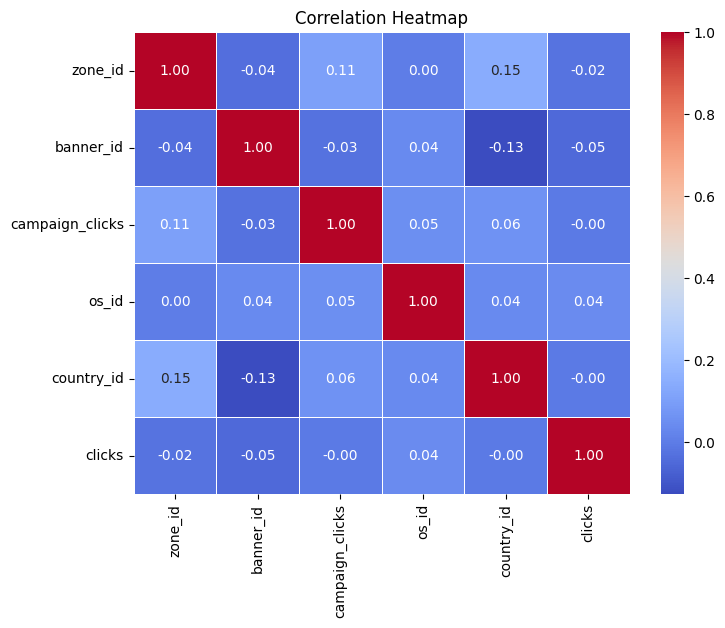

Отсуствует сильная корреляция между признаками, нет необходимости отбрасывать признаки (для построения устойчивого решения
Гистограммы распределения признаков от таргета


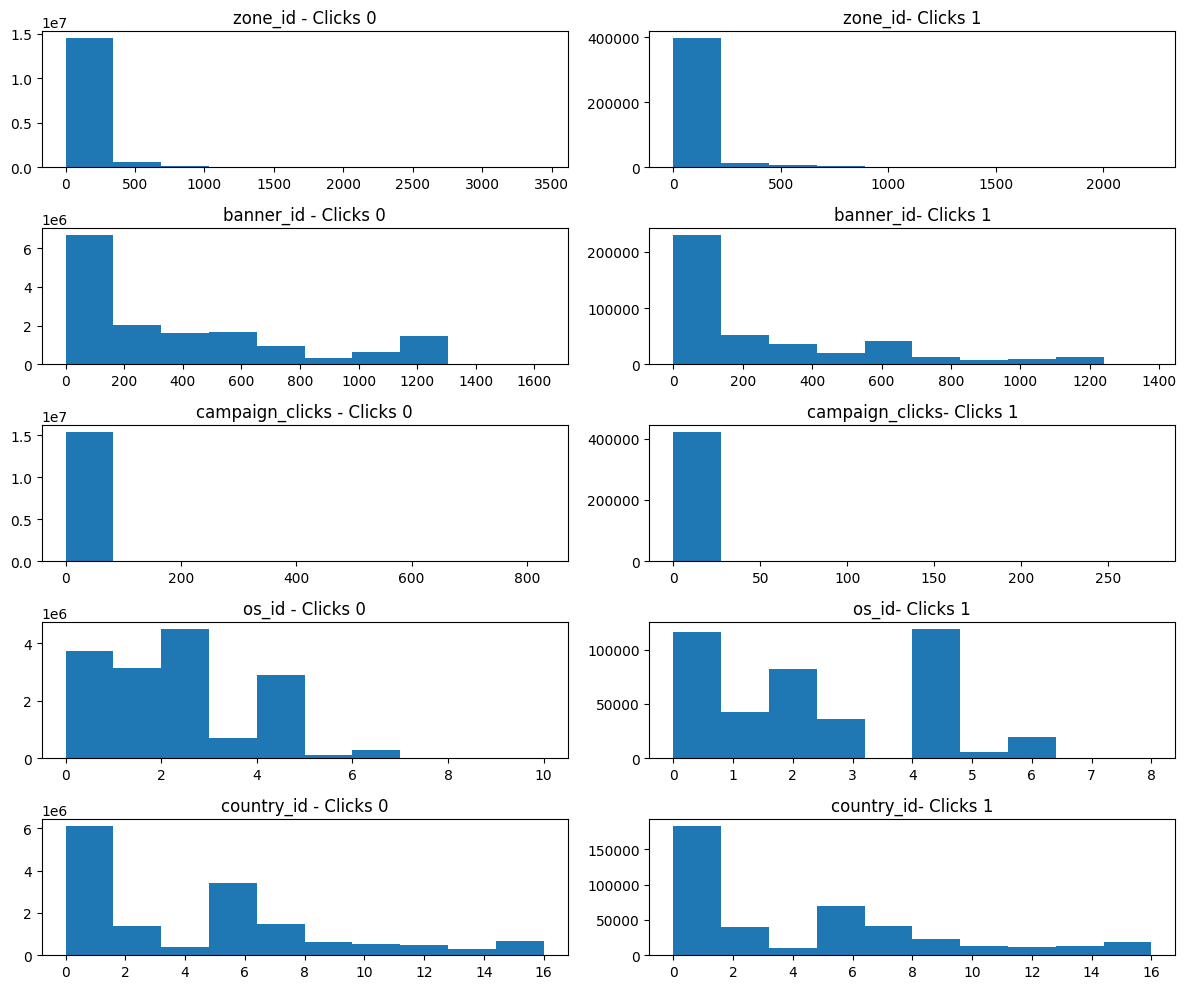

In [5]:
def analysis(data: pd.DataFrame):
    feats = ['zone_id','banner_id','campaign_clicks','os_id',
             'country_id'] ### у Impressions одно уникальное значение, поэтому дроп
    target = 'clicks'
    exploration_data  =pd.concat([data[feats],data[target]],axis=1)
    print('Распределение кликов по дням: ')
    
    display('Формат данных', exploration_data.head())
    display('Описание фичей и переменной',exploration_data.describe())
    display('Количество уникальных значений', exploration_data.nunique())
    print('По описанию все фичи являются категориальными (время пока не трогаем)')
    print('Распределение кликов по признакам:')
    df_corr = exploration_data.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()
    print('Отсуствует сильная корреляция между признаками, нет необходимости отбрасывать признаки (для построения устойчивого решения')
    print('Гистограммы распределения признаков от таргета')
    fig, axs = plt.subplots(len(feats), 2, figsize=(12, 10))
    for i,feat in enumerate(feats):
        axs[i][0].hist(exploration_data[exploration_data[target]==0][feat])
        axs[i][1].hist(exploration_data[exploration_data[target]==1][feat])
        axs[i][0].set_title(f'{feat} - Clicks 0')
        axs[i][1].set_title(f'{feat}- Clicks 1')
    fig.tight_layout()
    plt.show()
    
analysis(data)

In [6]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    encoder = LabelEncoder()
    # Выбрасываем мусор и прочее
    data = data.drop_duplicates()
    data = data.drop(columns=['impressions'],axis=1)
    data = data.drop(columns=['oaid_hash', 'banner_id0', 'banner_id1',
                          'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'],
                 axis=1)# Не нужны для первого дз
    data['year'] = data['date_time'].dt.year
    data['month'] = data['date_time'].dt.month
    data['day'] = data['date_time'].dt.day
    data['hour'] = data['date_time'].dt.hour
    data['minute'] = data['date_time'].dt.minute
    data['second'] = data['date_time'].dt.second
    data['campaign_ad'] = data['campaign_clicks'].apply(lambda x: int(bool(x))) # были ли показы от от данной компании
    data['is_day'] = data['hour'].apply(lambda x: 1 if int(x)>=12 and int(x) <=24 else 0) # Был ли показ днем
    data['is_night'] = data['is_day'].apply(lambda x: 1 if x==0 else 0) # Был ли показ ночью
    data['is_weekend'] = data['date_time'].apply(lambda x: 1 if x.weekday() > 4 else 0) # Был ли показ на выходных
    # Идея с комбинацией признаков не сработала (падало решение)
    # data['zone_banner_interaction'] = data['zone_id'].astype(str) + '_' + data['banner_id'].astype(str)
    # data['os_country_interaction'] = data['os_id'].astype(str) + '_' + data['country_id'].astype(str)
    # data['zone_banner_interaction_enc'] = encoder.fit_transform(data['zone_banner_interaction']) 
    # data['os_country_interaction_enc'] = encoder.fit_transform(data['os_country_interaction'])
    return data
data = feature_engineering(data)

In [7]:
feats = ['zone_id','banner_id','campaign_clicks','os_id','country_id','month','day','hour','campaign_ad',
        'is_day','is_night','is_weekend']
feats_to_transform = ['zone_id','banner_id','os_id','country_id']
raw_feats = [item for item in feats if item not in feats_to_transform]
target = 'clicks'


### Выделяем последний день для теста

In [8]:
end_last_day = data['date_time'].iloc[-1]
start_last_day = end_last_day - pd.to_timedelta(1, unit='d')

In [9]:
start_last_day

Timestamp('2021-10-01 23:59:59')

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
start_last_day

Timestamp('2021-10-01 23:59:59')

### Обучающая и валидационная выборка

In [12]:
X_train = data[(data['date_time']<start_last_day)][feats]
Y_train = data[(data['date_time']<start_last_day)][target]

In [13]:
X_test = data[(data['date_time']>start_last_day) & (data['date_time']<=end_last_day)][feats]
Y_test = data[(data['date_time']>start_last_day) & (data['date_time']<=end_last_day)][target]

### Кодируем категориальные признаки

In [14]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
X_train = ohe.fit_transform(X_train)
# X_val = ohe.transform(X_val)

/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Найдем K топовых признаков

In [15]:
feature_selector = SelectKBest(chi2, k=1000)

In [16]:
X_train = feature_selector.fit_transform(X_train, Y_train)
# X_val = feature_selector.transform(X_val)

### Не забываем про трансформацию теста:

In [17]:
X_test = ohe.transform(X_test)
X_test = feature_selector.transform(X_test)


### Метрики

In [18]:
from sklearn.metrics import log_loss,roc_auc_score, classification_report


### Baseline:

In [19]:
base_prediction = Y_train.mean()
base_prediction = np.full(X_test.shape[0],base_prediction)

In [20]:
print('Log_loss: ',log_loss(Y_test,base_prediction))
print('ROC AUC Score: ',roc_auc_score(Y_test,base_prediction))
print('Основные метрики: \n',classification_report(Y_test,base_prediction>0.5))

Log_loss:  0.15407884292463087
ROC AUC Score:  0.5


/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Основные метрики: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98   2053001
           1       0.00      0.00      0.00     74794

    accuracy                           0.96   2127795
   macro avg       0.48      0.50      0.49   2127795
weighted avg       0.93      0.96      0.95   2127795



/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Решение 1: CatBoostClassifier

In [21]:
from catboost import CatBoostClassifier

In [22]:
model = CatBoostClassifier(task_type="GPU")

In [23]:
%%time
model.fit(X_train,Y_train,verbose=False)

CPU times: user 2min 32s, sys: 22.9 s, total: 2min 55s
Wall time: 1min 42s


In [24]:
prediction = model.predict_proba(X_test)[:,1]

In [25]:
print('Catboost Results: ')
print('Log Loss: ',log_loss(Y_test,prediction))
print('ROCAUC Score: ',roc_auc_score(Y_test,prediction))
print('Основные метрики: \n\n',classification_report(Y_test,prediction>0.5))

Catboost Results: 
Log Loss:  0.13339830488154814
ROCAUC Score:  0.7780198635130349
Основные метрики: 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98   2053001
           1       0.87      0.01      0.01     74794

    accuracy                           0.97   2127795
   macro avg       0.92      0.50      0.50   2127795
weighted avg       0.96      0.97      0.95   2127795



### Решение 2 (для максимального балла использовать логистическую регрессию c покоординатным спуском через liblinear )

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV

In [27]:
model = LogisticRegression(solver='liblinear', penalty='l2')

In [28]:
%%time
model.fit(X_train,Y_train)

CPU times: user 6min 43s, sys: 19.5 s, total: 7min 3s
Wall time: 7min 3s


LogisticRegression(solver='liblinear')

In [29]:
prediction = model.predict_proba(X_test)[:,1]

In [30]:
print('LogReg Results: ')
print('Log Loss: ',log_loss(Y_test,prediction))
print('ROCAUC Score: ',roc_auc_score(Y_test,prediction))
print('Основные метрики: \n\n',classification_report(Y_test,prediction>0.5))

LogReg Results: 
Log Loss:  0.1369860180512297
ROCAUC Score:  0.7791786379725736
Основные метрики: 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98   2053001
           1       0.58      0.01      0.01     74794

    accuracy                           0.96   2127795
   macro avg       0.77      0.50      0.50   2127795
weighted avg       0.95      0.96      0.95   2127795



In [37]:
def create_model():
    return LogisticRegression(solver='liblinear', penalty='l2')

In [43]:
def cv(X_train,Y_train): ### Подбираем параметр C
    model = create_model()
    param_search = {'C' : [0.001, 0.01, 0.1, 1.]}

    splits = TimeSeriesSplit(n_splits=3)
    clf = GridSearchCV(estimator=model, cv=splits,
                            param_grid=param_search, verbose=10, scoring=['roc_auc', 'neg_log_loss'], refit="neg_log_loss")
    clf.fit(X_train, Y_train)
    
    return clf

In [44]:
%%time
best_model = cv(X_train,Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START C=0.001.....................................................
[CV 1/3; 1/4] END C=0.001; neg_log_loss: (test=-0.086) roc_auc: (test=0.670) total time=   8.8s
[CV 2/3; 1/4] START C=0.001.....................................................
[CV 2/3; 1/4] END C=0.001; neg_log_loss: (test=-0.113) roc_auc: (test=0.670) total time=  19.4s
[CV 3/3; 1/4] START C=0.001.....................................................
[CV 3/3; 1/4] END C=0.001; neg_log_loss: (test=-0.151) roc_auc: (test=0.731) total time=  32.8s
[CV 1/3; 2/4] START C=0.01......................................................
[CV 1/3; 2/4] END C=0.01; neg_log_loss: (test=-0.084) roc_auc: (test=0.696) total time=  14.5s
[CV 2/3; 2/4] START C=0.01......................................................
[CV 2/3; 2/4] END C=0.01; neg_log_loss: (test=-0.110) roc_auc: (test=0.701) total time=  39.1s
[CV 3/3; 2/4] START C=0.01...............................

# Итог:

In [45]:
base_prediction = Y_train.mean()
base_prediction = np.full(len(Y_test),base_prediction)

In [46]:
print('Baseline Results: ')
print('Log Loss: ',log_loss(Y_test,base_prediction))
print('ROCAUC Score: ',roc_auc_score(Y_test,base_prediction))
print('Основные метрики: \n\n',classification_report(Y_test,base_prediction>0.5))

prediction = best_model.predict_proba(X_test)[:,1]
print('LogReg Results: ')
print('Log Loss: ',log_loss(Y_test,prediction))
print('ROCAUC Score: ',roc_auc_score(Y_test,prediction))
print('Основные метрики: \n\n',classification_report(Y_test,prediction>0.5))

Baseline Results: 
Log Loss:  0.15407884292463087
ROCAUC Score:  0.5


/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kotvkaskepc/anaconda3/envs/gpuenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Основные метрики: 

               precision    recall  f1-score   support

           0       0.96      1.00      0.98   2053001
           1       0.00      0.00      0.00     74794

    accuracy                           0.96   2127795
   macro avg       0.48      0.50      0.49   2127795
weighted avg       0.93      0.96      0.95   2127795

LogReg Results: 
Log Loss:  0.13672160020962554
ROCAUC Score:  0.7791441404239191
Основные метрики: 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98   2053001
           1       0.59      0.01      0.01     74794

    accuracy                           0.96   2127795
   macro avg       0.78      0.50      0.50   2127795
weighted avg       0.95      0.96      0.95   2127795



### Т.о полученные выше модели превосходят бейзлайн по качеству предсказания вероятности отклика